In [1]:
#!pip install spacy-langdetect
#!pip install language-detector
#!pip install symspellpy
#!pip install sentence-transformers

# 1. Read dataset.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
meta = pd.read_csv("../metadata.csv")
print(meta.shape)
meta.head()

C:\Users\zhipe\Anaconda3\envs\tm\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(341713, 19)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


Filter meta file by selecting only papers after 2020.

In [4]:
meta["publish_time"] = pd.to_datetime(meta["publish_time"])
meta["publish_year"] = pd.DatetimeIndex(meta['publish_time']).year
meta["publish_month"] = pd.DatetimeIndex(meta['publish_time']).month
meta = meta[meta["publish_year"] == 2020]
print(meta.shape[0], " papers are available after 2020 Jan 1.")

247255  papers are available after 2020 Jan 1.


Create dataframe with all abstracts and use it as input corpus.

In [5]:
index = []
for i in range(len(meta)):
    if type(meta.iloc[i, 8]) != float:
        index.append(i)
docs = meta.iloc[index, 8]
docs = docs.reset_index(drop= True)
print(docs.shape)
docs.head()

(163820,)


0    BACKGROUND: Dexmedetomidine has been reported ...
1    BACKGROUND: Global end-diastolic volume (GEDV)...
2    BACKGROUND: Human metapneumovirus (HMPV) is an...
3    BACKGROUND: Antimicrobial resistance (AMR) com...
4    Glycoconjugate vaccines based on bacterial cap...
Name: abstract, dtype: object

In [6]:
samp_size = 5100 #51000
samp_docs = docs.sample(n=samp_size,random_state=100)

# 2. Preprocessing texts

Sentence level preprocess
* Lowercase + base filter
* Some basic normalization

In [7]:
import re
def preprocess_sent(rw):
    """
    Get sentence level preprocessed data from raw review texts
    :param rw: review to be processed
    :return: sentence level pre-processed review
    """
    # Add missing delimiter: xxxThis is a --> xxx.
    s = re.sub(r'([a-z])([A-Z])', r'\1\. \2', rw)  # before lower case
    # Make words all lower case.
    s = s.lower()
    # Remove < and >
    s = re.sub(r'&gt|&lt', ' ', s)
    # Remove letters that repeat more than 2 time.
    s = re.sub(r'([a-z])\1{2,}', r'\1', s)
    # Remove non-word characters that repeat more than 1 time.
    s = re.sub(r'([\W+])\1{1,}', r'\1', s)
    # Use string * as delimiter
    s = re.sub(r'\*|\W\*|\*\W', '. ', s)
    # Remove words in parenthesis, which are assumed less informal
    s = re.sub(r'\(.*?\)', '. ', s)
    # xxx[?!]. -- > xxx.
    s = re.sub(r'\W+?\.', '.', s)
    # [.?!]xxx --> [.?!] xxx
    s = re.sub(r'(\.|\?|!)(\w)', r'\1 \2', s)
    return s.strip()

text_lists = [preprocess_sent(text) for text in samp_docs]

 Word level preprocess

In [8]:
# define stemmer
import nltk
from nltk.stem.porter import *
p_stemmer = PorterStemmer()

# create stop words list
from stop_words import get_stop_words
stop_words = (list(
    set(get_stop_words('en'))
    |set(get_stop_words('es'))
    |set(get_stop_words('de'))
    |set(get_stop_words('it'))
    |set(get_stop_words('ca'))
    |set(get_stop_words('pt'))
    |set(get_stop_words('pl'))
    |set(get_stop_words('da'))
    |set(get_stop_words('ru'))
    |set(get_stop_words('sv'))
    |set(get_stop_words('sk'))
    |set(get_stop_words('nl'))
    |set(["abstract"])
))

In [9]:
from nltk.tokenize import word_tokenize
def preprocess_word(s):
    """
    Get word level preprocessed data from preprocessed sentences
    including: remove punctuation, select noun, fix typo, stem, stop_words
    :param s: sentence to be processed
    :return: word level pre-processed review
    """
    if not s:
        return None
    w_list = word_tokenize(s)
    w_list = [word for word in w_list if word.isalpha()]
    w_list = [word for (word, pos) in nltk.pos_tag(w_list) if pos[:2] == 'NN']
    w_list = [word for word in w_list if word not in stop_words]
    w_list = [p_stemmer.stem(word) for word in w_list]

    return w_list

token_lists = [preprocess_word(text) for text in text_lists]

In [10]:
docs_token = [(samp_docs.iloc[i], token_lists[i]) for i in range(len(samp_docs)) if token_lists[i] != []]
samp_pd = pd.DataFrame.from_records(docs_token, columns=['Abstract','Token'])
samp_pd.head()

,Abstract,Token
0,BACKGROUND: Different skin manifestations of C...,"[background, manifest, lesion, hand, feet, chi..."
1,SARS-CoV-2 is the cause of the worldwide outbr...,"[caus, outbreak, report, decemb, case, death, ..."
2,BACKGROUND: Multiple professional bodies have ...,"[background, bodi, recommend, diabet, criteria..."
3,Severe cases of COVID-19 are characterized by ...,"[case, inflammatori, process, failur, death, i..."
4,The COVID-19 pandemic caused by the SARS-CoV-2...,"[pandem, viru, ten, thousand, death, spain, he..."


# 4. Define model object

In [11]:
import gensim
from gensim import corpora, models

In [12]:
ntopic = 10
token_lists = samp_pd.Token.to_list()
dictionary = corpora.Dictionary(token_lists)
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in token_lists]
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=ntopic, random_state=66, id2word=dictionary, passes=20)

In [13]:
for topic in lda_model.print_topics():
    print(topic)

(0, '0.019*"mask" + 0.014*"air" + 0.014*"surfac" + 0.010*"product" + 0.009*"market" + 0.008*"hand" + 0.008*"emiss" + 0.007*"disinfect" + 0.007*"effect" + 0.007*"particl"')
(1, '0.040*"health" + 0.024*"care" + 0.019*"pandem" + 0.015*"system" + 0.011*"research" + 0.011*"servic" + 0.011*"commun" + 0.010*"manag" + 0.010*"challeng" + 0.009*"respons"')
(2, '0.041*"case" + 0.023*"infect" + 0.021*"diseas" + 0.017*"number" + 0.016*"countri" + 0.016*"coronaviru" + 0.014*"transmiss" + 0.014*"rate" + 0.013*"data" + 0.013*"outbreak"')
(3, '0.032*"student" + 0.024*"d" + 0.013*"educ" + 0.011*"patient" + 0.007*"dan" + 0.007*"vitamin" + 0.006*"teach" + 0.006*"learn" + 0.005*"univers" + 0.005*"faculti"')
(4, '0.030*"model" + 0.021*"studi" + 0.017*"data" + 0.014*"result" + 0.014*"method" + 0.011*"analysi" + 0.011*"anxieti" + 0.010*"level" + 0.009*"knowledg" + 0.009*"inform"')
(5, '0.029*"cell" + 0.017*"drug" + 0.017*"infect" + 0.016*"protein" + 0.014*"vaccin" + 0.012*"viru" + 0.011*"activ" + 0.011*"respo

# 5. Post-analysis
The Dominant topic and its percentage contribution in each document

In [14]:
def dominant_topic(ldamodel, corpus, texts):
    # Init output
    topic_df = pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        topic_num,prop_topic = row[0]
        topic_keywords = ", ".join([word for word, prop in ldamodel.show_topic(topic_num)])
        topic_df = topic_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
    topic_df = pd.concat([topic_df, texts], axis=1)
    topic_df.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Abstract']
    return(topic_df)

topic_keywords_df = dominant_topic(ldamodel=lda_model, corpus=corpus, texts=samp_pd.Abstract)
topic_keywords_df.head(3)

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Abstract
0,7.0,0.6836,"patient, diseas, studi, treatment, infect, ris...",BACKGROUND: Different skin manifestations of C...
1,5.0,0.4842,"cell, drug, infect, protein, vaccin, viru, act...",SARS-CoV-2 is the cause of the worldwide outbr...
2,6.0,0.5158,"studi, women, trial, particip, use, review, ri...",BACKGROUND: Multiple professional bodies have ...


Find the most representative abstract for each topic

In [15]:
pd.options.display.max_colwidth = 50
topic_representative_text = pd.DataFrame()
for i, grp in topic_keywords_df.groupby('Dominant_Topic'):
    topic_representative_text = topic_representative_text.append(
        grp.sort_values(['Topic_Perc_Contrib'], ascending=False).iloc[0]
    )

topic_representative_text.reset_index(drop=True, inplace=True)
topic_representative_text.columns = ["Representative Text","Topic_Num", "Keywords", "Topic_Perc_Contrib"]
topic_representative_text.head(10)

,Representative Text,Topic_Num,Keywords,Topic_Perc_Contrib
0,"La nueva enfermedad por coronavirus, también d...",0.0,"mask, air, surfac, product, market, hand, emis...",0.9826
1,Background: The cororavirus disease 19 (COVID-...,1.0,"health, care, pandem, system, research, servic...",0.9917
2,"BACKGROUND: As of 16 May 2020, more than 4.5 m...",2.0,"case, infect, diseas, number, countri, coronav...",0.9930
3,"Introduction En France, une mesure exceptionne...",3.0,"student, d, educ, patient, dan, vitamin, teach...",0.9777
4,As the main place of people’s daily activities...,4.0,"model, studi, data, result, method, analysi, a...",0.9902
5,"Until now, no approved effective vaccine and a...",5.0,"cell, drug, infect, protein, vaccin, viru, act...",0.9878
6,Delirium is a common neurocognitive disorder i...,6.0,"studi, women, trial, particip, use, review, ri...",0.9830
7,Objective: To investigate the causes of death ...,7.0,"patient, diseas, studi, treatment, infect, ris...",0.9927
8,"Metagenomic next-generation sequencing (mNGS),...",8.0,"test, sampl, detect, antibodi, method, result,...",0.9861
9,A 43-year-old man underwent a low anterior res...,9.0,"cancer, surgeri, patient, procedur, practic, t...",0.9857


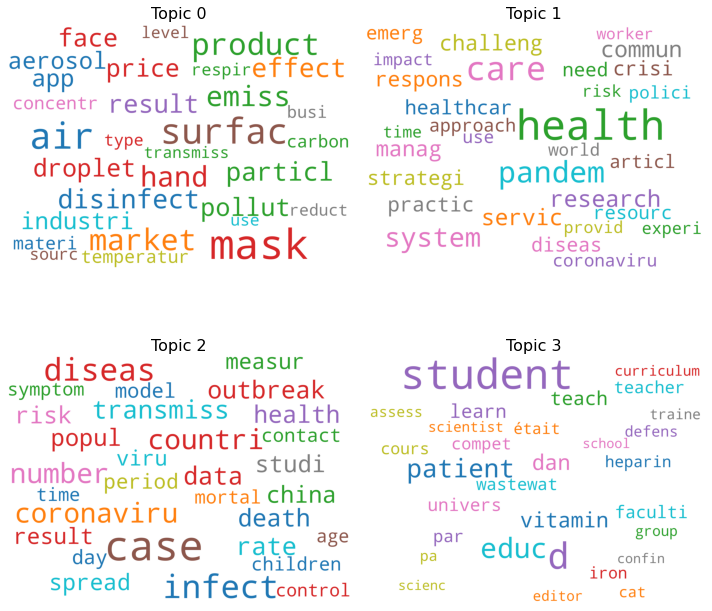

In [16]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(
                # stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  # max_words=10,
                  colormap='tab10',
                  # color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0
                  )

topics = lda_model.show_topics(num_words=30, formatted=False)
fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

# plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
# plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Use pyLDAvis tool to perform visualization.

In [17]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.122674 -0.036649       1        1  21.075061
1     -0.101440 -0.097310       2        1  16.030327
2     -0.169463 -0.010074       3        1  15.331466
5     -0.056886  0.156431       4        1  13.703175
4     -0.096162  0.013866       5        1  11.284785
6     -0.076368 -0.090384       6        1   6.715975
8      0.091685  0.205086       7        1   4.885443
9      0.070980 -0.170349       8        1   4.647686
0      0.131227  0.147197       9        1   3.607284
3      0.329100 -0.117815      10        1   2.718798, topic_info=         Term         Freq        Total Category  logprob  loglift
31    patient  7089.000000  7089.000000  Default  30.0000  30.0000
6        case  2571.000000  2571.000000  Default  29.0000  29.0000
170    health  2810.000000  2810.000000  Default  28.0000  28.0000
49       cell  1218.000000  1218.000000  Default  27.0000  27.0000
71      studi  3440.000000  3440.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
263    assess    26.738492   300.927882  Topic10  -5.6981   1.1842
3273   confin    21.973693    45.246044  Topic10  -5.8943   2.8827
134     group    25.974608  1335.833710  Topic10  -5.7271  -0.3352
1619   school    22.490333   121.552948  Topic10  -5.8711   1.9177
710    scienc    22.659989   222.100724  Topic10  -5.8636   1.3224

[711 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
6168      5  0.978930        ab
577       1  0.987241    abnorm
577       3  0.012188    abnorm
860       6  0.691050    accept
860       7  0.248069    accept
...     ...       ...       ...
99        9  0.005616      year
99       10  0.022465      year
1593      3  0.927197  zhejiang
3393     10  0.986534     était
3395     10  0.953496       été

[1702 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 3, 6, 5, 7, 9, 10, 1, 4])